# MODELO LSTM PARA SERIES TEMPORALES DE PRECIO (TRADING ALGORITMICO)

## Importación y tratamiento inicial del dataset

In [1]:
import pandas as pd
import numpy as np

ruta_archivo = "todos_1d_10y.csv"
simbolo_activo = "EURUSD=X"
columna_fecha = 'datetime'
columna_precio = 'Close'

In [2]:
df_completo = pd.read_csv(ruta_archivo)
df = df_completo[df_completo['symbol'].astype(str).str.upper()==simbolo_activo.upper()].copy()
df[columna_fecha] = pd.to_datetime(df[columna_fecha])
df.set_index(columna_fecha, inplace=True)
df.sort_index(inplace=True)
columnas_base = [columna_precio]
columnas_opcionales = ['Open', 'High', 'Low', 'Volume']
columnas_finales = columnas_base +[col for col in columnas_opcionales if col in df.columns]
df = df[columnas_finales].copy()
df.dropna(subset=[columna_precio], inplace=True)

In [3]:
print(f"Registros cargados: {len(df)}")
print(f"Rango de fechas: {df.index.min()} a {df.index.max()}")
df.head()

Registros cargados: 2600
Rango de fechas: 2015-11-30 00:00:00 a 2025-11-24 00:00:00


,Close,Open,High,Low,Volume
datetime,,,,,
2015-11-30,1.058302,1.058302,1.059704,1.056400,0
2015-12-01,1.057295,1.057295,1.064000,1.056602,0
2015-12-02,1.062586,1.062699,1.064000,1.056201,0
2015-12-03,1.061301,1.061199,1.089200,1.054200,0
2015-12-04,1.091596,1.091834,1.095194,1.085800,0


In [4]:
df_caracteristicas = df.copy()
df_caracteristicas['retornos'] = df_caracteristicas[columna_precio].pct_change()
df_caracteristicas['sma_10'] = df_caracteristicas[columna_precio].rolling(10, min_periods=1).mean()
df_caracteristicas['sma_30'] = df_caracteristicas[columna_precio].rolling(30, min_periods=1).mean()
if 'Volume' in df_caracteristicas.columns:
    mediana_volumen = df_caracteristicas['Volume'].median()
    df_caracteristicas['Volume'].fillna(mediana_volumen, inplace=True)
    df_caracteristicas['volumen_sma'] = df_caracteristicas['Volume'].rolling(10, min_periods=1).mean()
    df_caracteristicas['volumen_sma'].fillna(df_caracteristicas['volumen_sma'].median(), inplace=True)


In [5]:
df_caracteristicas.fillna(method='ffill', inplace=True) 
df_caracteristicas.fillna(method='bfill', inplace=True)
df_caracteristicas.dropna(inplace=True)

C:\Users\daparohe\AppData\Local\Temp\ipykernel_38072\1759160318.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_caracteristicas.fillna(method='ffill', inplace=True)
C:\Users\daparohe\AppData\Local\Temp\ipykernel_38072\1759160318.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_caracteristicas.fillna(method='bfill', inplace=True)


In [6]:
print(f"Datos después del preprocesamiento: {len(df_caracteristicas)} registros")
print(f"Columnas de características: {df_caracteristicas.columns.tolist()}")

Datos después del preprocesamiento: 2600 registros
Columnas de características: ['Close', 'Open', 'High', 'Low', 'Volume', 'retornos', 'sma_10', 'sma_30', 'volumen_sma']


## Creación de ventanas de tiempo

Escalamiento de los datos

In [7]:
from sklearn.preprocessing import MinMaxScaler

ventana_tiempo = 60  #días hacia atrás para predecir
tamano_prueba = 0.2  #20% para prueba
escalador = MinMaxScaler()
datos_escalados = escalador.fit_transform(df_caracteristicas.values)
X, y = [], []
indice_columna_precio = df_caracteristicas.columns.get_loc(columna_precio)
for i in range(ventana_tiempo, len(datos_escalados)):
    X.append(datos_escalados[i-ventana_tiempo:i])
    y.append(datos_escalados[i, indice_columna_precio])
X, y = np.array(X), np.array(y)
indice_division = int(len(X) * (1 - tamano_prueba))
X_entrenamiento, X_prueba = X[:indice_division], X[indice_division:]
y_entrenamiento, y_prueba = y[:indice_division], y[indice_division:]
print(f"Secuencias de entrenamiento: {len(X_entrenamiento)}",f"Secuencias de prueba: {len(X_prueba)}",f"Forma de entrada (Input Shape): {X_entrenamiento.shape[1:]}",sep="\n")

Secuencias de entrenamiento: 2032
Secuencias de prueba: 508
Forma de entrada (Input Shape): (60, 9)


## Creación del modelo LSTM

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

modelo = Sequential([
    LSTM(128, return_sequences=True,input_shape=(X_entrenamiento.shape[1], X_entrenamiento.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dense(32),
    Dense(1)
])

modelo.compile(optimizer='adam', loss='mse', metrics=['mae'])
modelo.summary()

c:\Users\daparohe\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,177 (477.25 KB)

 Trainable params: 122,177 (477.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0252 - mae: 0.1046 - val_loss: 0.0012 - val_mae: 0.0269
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0017 - mae: 0.0321 - val_loss: 0.0010 - val_mae: 0.0250
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0015 - mae: 0.0310 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0013 - mae: 0.0274 - val_loss: 7.0363e-04 - val_mae: 0.0205
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0012 - mae: 0.0268 - val_loss: 5.5265e-04 - val_mae: 0.0182
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.6385e-04 - mae: 0.0244 - val_loss: 6.2865e-04 - val_mae: 0.0198
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.8555e-04 - mae: 0.0232 - val_loss: 3.8106e-04 - val_mae: 0.0147
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.2615e-04 - mae: 0.0209 - val_loss: 6.1716e-04 - val_mae: 0.0200
Epoch 9/

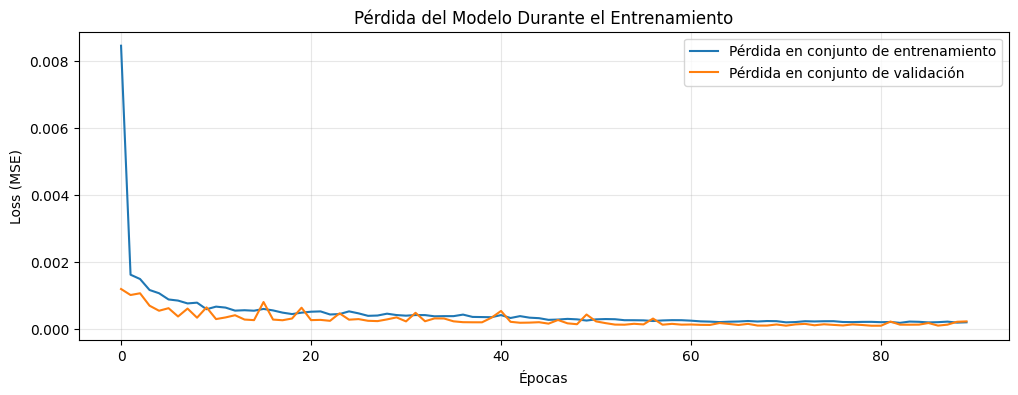

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

parada_temprana = [EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True,verbose=1)]

historial = modelo.fit(X_entrenamiento,y_entrenamiento,validation_data=(X_prueba,y_prueba),epochs=100,batch_size=16,callbacks=parada_temprana,verbose=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(historial.history['loss'], label='Pérdida en conjunto de entrenamiento')
plt.plot(historial.history['val_loss'], label='Pérdida en conjunto de validación')
plt.title('Pérdida del Modelo Durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Evaluación del modelo

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

predicciones_escaladas = modelo.predict(X_prueba, verbose=0)

mse_lstm = mean_squared_error(y_prueba, predicciones_escaladas)
mae_lstm = mean_absolute_error(y_prueba, predicciones_escaladas)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((y_prueba - predicciones_escaladas)/y_prueba)) * 100
r2_lstm = r2_score(y_prueba, predicciones_escaladas)
accuracy_lstm = 1 - (mae_lstm / np.mean(y_prueba))
print(f"MSE: {mse_lstm:.6f}",f"RMSE: {rmse_lstm:.6f}",f"MAE: {mae_lstm:.6f}",f"R^2: {r2_lstm:.4f}",f"Accuracy: {accuracy_lstm:.2%}",f"MAPE: {mape_lstm:.2f}%",sep="\n")

MSE: 0.000105
RMSE: 0.010271
MAE: 0.007235
R^2: 0.9949
Accuracy: 98.52%
MAPE: 35.98%


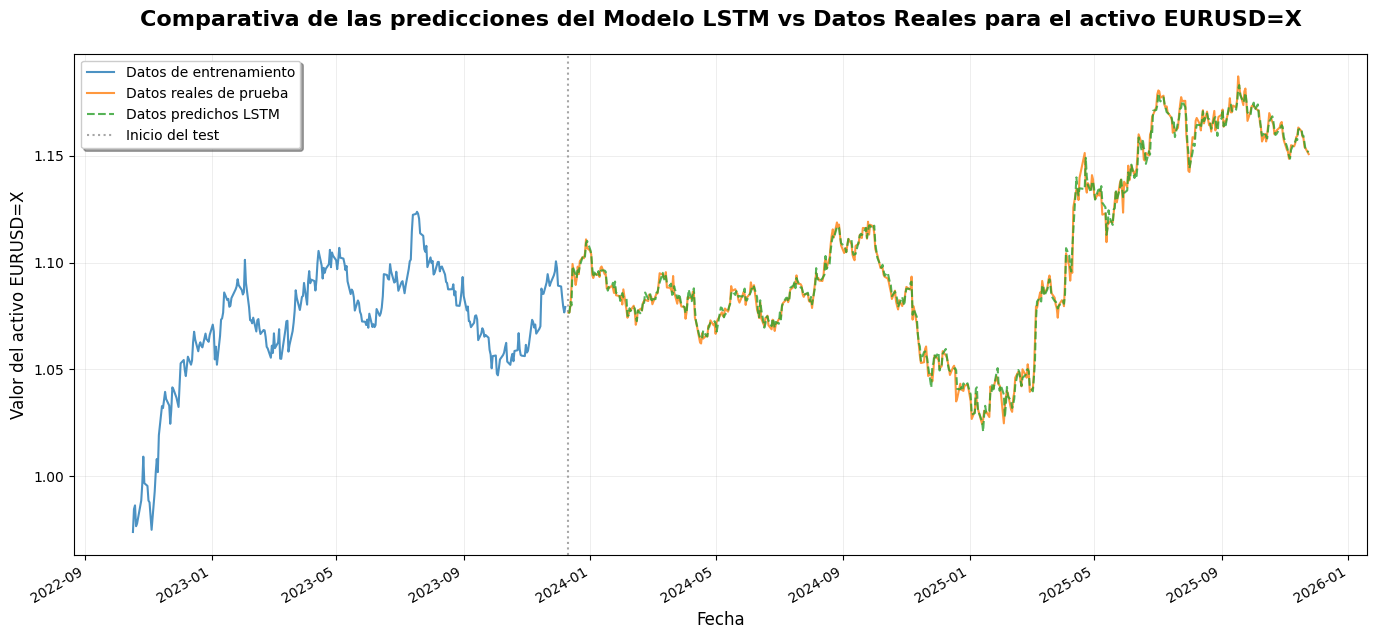


MÉTRICAS DE EVALUACIÓN DEL MODELO
MAE (Error Absoluto Medio):        0.0021
RMSE (Raíz del Error Cuadrático):  0.0030
R² Score:                          0.9949
MAPE (Error Porcentual Medio):     0.19%



In [11]:
datos_entrenamiento_mostrar = 300

def des_escalar(datos_1d, escalador, indice_columna):
    datos_1d = np.array(datos_1d).reshape(-1, 1)
    dummy = np.zeros((len(datos_1d), escalador.n_features_in_))
    dummy[:, indice_columna] = datos_1d.flatten()
    datos_desescalados = escalador.inverse_transform(dummy)[:, indice_columna]
    return datos_desescalados

indice_columna_precio = df_caracteristicas.columns.get_loc(columna_precio)
predicciones_reales = des_escalar(predicciones_escaladas, escalador, indice_columna_precio)
valores_reales = des_escalar(y_prueba, escalador, indice_columna_precio)
valores_entrenamiento = des_escalar(y_entrenamiento, escalador, indice_columna_precio)

inicio_entrenamiento = max(0, len(valores_entrenamiento) - datos_entrenamiento_mostrar)
fechas_entrenamiento = df.index[ventana_tiempo + inicio_entrenamiento:ventana_tiempo + len(valores_entrenamiento)]
valores_entrenamiento_mostrar = valores_entrenamiento[inicio_entrenamiento:]
fechas_prueba = df.index[ventana_tiempo + len(valores_entrenamiento):ventana_tiempo + len(valores_entrenamiento) + len(valores_reales)]

plt.figure(figsize=(14, 7))
plt.plot(fechas_entrenamiento, valores_entrenamiento_mostrar, label='Datos de entrenamiento', color='#1f77b4', linewidth=1.5, alpha=0.8)
plt.plot(fechas_prueba, valores_reales, label='Datos reales de prueba', color='#ff7f0e', linewidth=1.5, alpha=0.8)
plt.plot(fechas_prueba, predicciones_reales, label='Datos predichos LSTM', color='#2ca02c', linewidth=1.5, linestyle='--', alpha=0.8)
plt.axvline(x=fechas_prueba[0], color='gray', linestyle=':', linewidth=1.5, label='Inicio del test', alpha=0.7)
plt.title('Comparativa de las predicciones del Modelo LSTM vs Datos Reales para el activo EURUSD=X', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor del activo EURUSD=X', fontsize=12)
plt.legend(loc='upper left', frameon=True, shadow=True, fontsize=10)
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

mae = mean_absolute_error(valores_reales, predicciones_reales)
rmse = np.sqrt(mean_squared_error(valores_reales, predicciones_reales))
r2 = r2_score(valores_reales, predicciones_reales)
mape = np.mean(np.abs((valores_reales - predicciones_reales) / valores_reales)) * 100
print(f"\n{'='*50}")
print(f"MÉTRICAS DE EVALUACIÓN DEL MODELO")
print(f"{'='*50}")
print(f"MAE (Error Absoluto Medio):        {mae:.4f}")
print(f"RMSE (Raíz del Error Cuadrático):  {rmse:.4f}")
print(f"R² Score:                          {r2:.4f}")
print(f"MAPE (Error Porcentual Medio):     {mape:.2f}%")
print(f"{'='*50}\n")

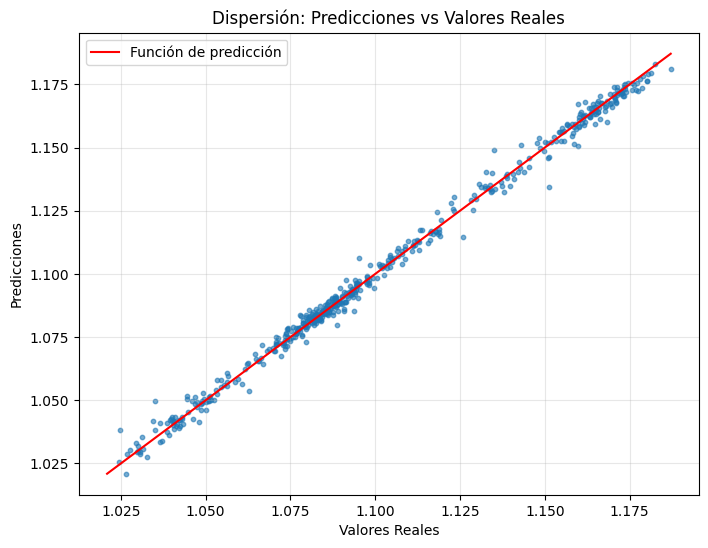

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(valores_reales, predicciones_reales, alpha=0.6, s=10)
val_min, val_max = min(valores_reales.min(), predicciones_reales.min()), max(valores_reales.max(), predicciones_reales.max())
plt.plot([val_min, val_max], [val_min, val_max], 'r', label='Función de predicción')
plt.title('Dispersión: Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
error_real = np.abs(valores_reales - predicciones_reales)
print("\nEstadísticas del error (Precio Real):",f"Error promedio: {error_real.mean():.4f}",f"Error mediano: {np.median(error_real):.4f}",f"Error máximo: {error_real.max():.4f}",sep="\n")


Estadísticas del error (Precio Real):
Error promedio: 0.0021
Error mediano: 0.0015
Error máximo: 0.0169


## Walk Forward temporal

In [14]:
from tensorflow.keras.models import clone_model

ventana_reentrenamiento = 30
predicciones_walk_forward = []
valores_reales_walk_forward = []

modelo_wf = clone_model(modelo)
modelo_wf.set_weights(modelo.get_weights())
modelo_wf.compile(optimizer='adam', loss='mse', metrics=['mae'])

for i in range(len(X_prueba)):
    prediccion = modelo_wf.predict(X_prueba[i:i+1], verbose=0)
    predicciones_walk_forward.append(prediccion[0, 0])
    valores_reales_walk_forward.append(y_prueba[i])
    
    if (i + 1) % ventana_reentrenamiento == 0 and i < len(X_prueba) - 1:
        X_nuevo = np.vstack([X_entrenamiento, X_prueba[:i+1]])
        y_nuevo = np.concatenate([y_entrenamiento, y_prueba[:i+1]])
        modelo_wf.fit(X_nuevo, y_nuevo, epochs=3, batch_size=32, verbose=0)

predicciones_walk_forward = np.array(predicciones_walk_forward)
valores_reales_walk_forward = np.array(valores_reales_walk_forward)

mae_wf = mean_absolute_error(valores_reales_walk_forward, predicciones_walk_forward)
print(f"MAE Walk-Forward: {mae_wf:.4f}")

MAE Walk-Forward: 0.0086


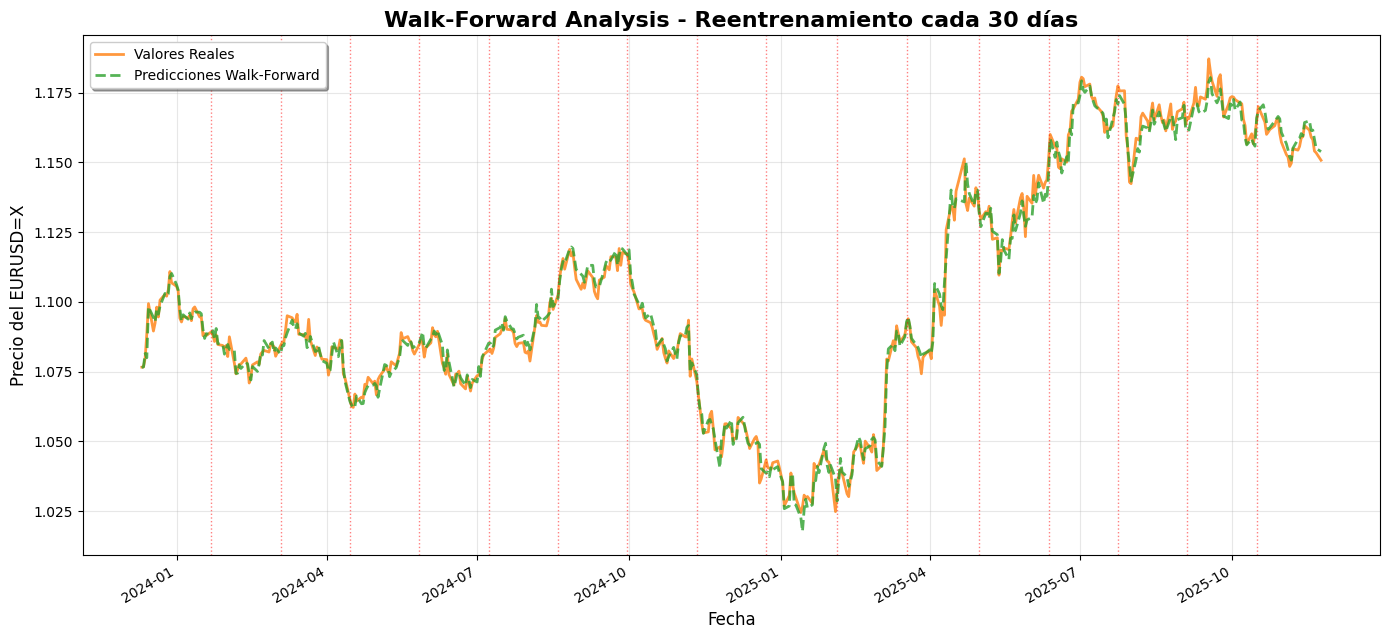

Total de reentrenamientos: 16


In [16]:
predicciones_wf_reales = des_escalar(predicciones_walk_forward, escalador, indice_columna_precio)
valores_wf_reales = des_escalar(valores_reales_walk_forward, escalador, indice_columna_precio)
fechas_wf = df.index[ventana_tiempo + len(valores_entrenamiento):ventana_tiempo + len(valores_entrenamiento) + len(valores_wf_reales)]

plt.figure(figsize=(14, 7))
plt.plot(fechas_wf, valores_wf_reales, label='Valores Reales', color='#ff7f0e', linewidth=2, alpha=0.8)
plt.plot(fechas_wf, predicciones_wf_reales, label='Predicciones Walk-Forward', color='#2ca02c', linewidth=2, linestyle='--', alpha=0.8)

for i in range(0, len(fechas_wf), ventana_reentrenamiento):
    if i > 0:
        plt.axvline(x=fechas_wf[i], color='red', linestyle=':', linewidth=1, alpha=0.5)

plt.title('Walk-Forward Analysis - Reentrenamiento cada ' + str(ventana_reentrenamiento) + ' días', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio del EURUSD=X', fontsize=12)
plt.legend(loc='upper left', frameon=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

print(f"Total de reentrenamientos: {len(predicciones_walk_forward) // ventana_reentrenamiento}")

## Desarrollo de ARIMA

In [42]:
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

precios = df_caracteristicas['Close']
tamano_prueba = 0.2
indice_division = int(len(precios) * (1 - tamano_prueba))
precios_entrenamiento = precios[:indice_division]
precios_prueba = precios[indice_division:]

ordenes = [(p, 1, q) for p in range(0, 6) for q in range(0, 6)]
mejor_aic = np.inf
mejor_orden = None
mejores_predicciones = None

print("Buscando mejor orden ARIMA...")
for orden in ordenes:
    try:
        m = ARIMA(precios_entrenamiento, order=orden)
        res = modelo.fit()
        if res.aic < mejor_aic:
            mejor_aic = res.aic
            mejor_orden = orden
            mejores_predicciones = res.forecast(steps=len(precios_prueba))
            print(f"Nuevo mejor: {orden} - AIC: {res.aic:.2f}")
    except:
        continue

print(f"\nMejor orden encontrado: {mejor_orden} con AIC: {mejor_aic:.2f}")

Buscando mejor orden ARIMA...


c:\Users\daparohe\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\daparohe\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\daparohe\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\daparohe\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported 

Nuevo mejor: (0, 1, 0) - AIC: -15935.09


c:\Users\daparohe\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\daparohe\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\daparohe\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\daparohe\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index 


Mejor orden encontrado: (0, 1, 0) con AIC: -15935.09


c:\Users\daparohe\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\daparohe\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\daparohe\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\daparohe\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported 

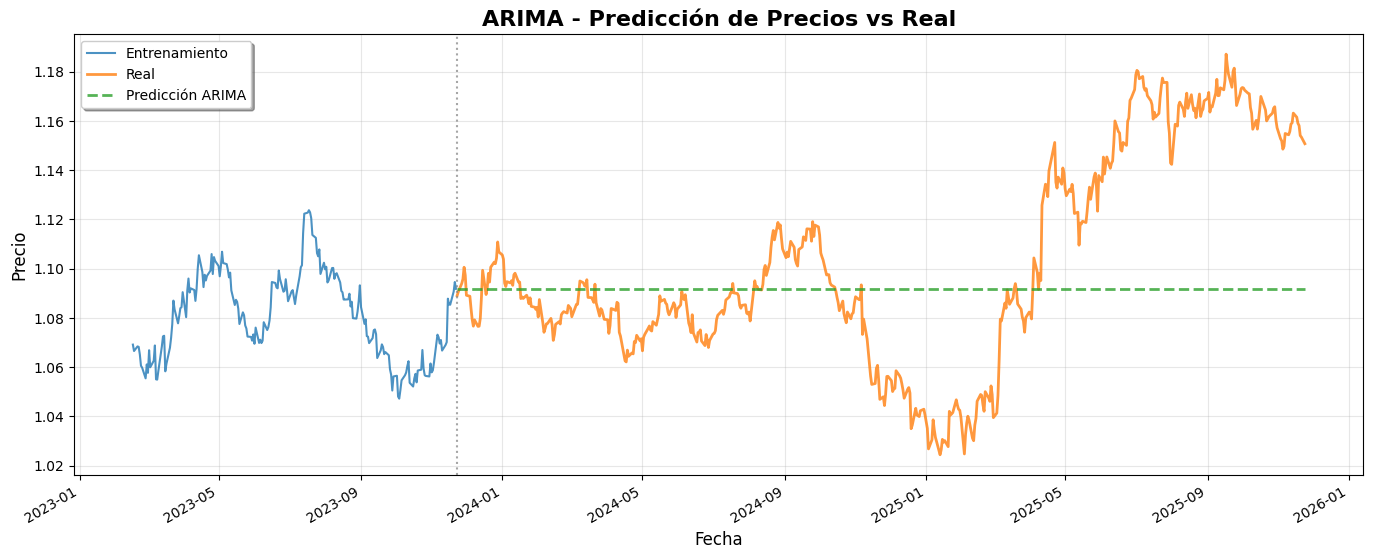

MSE: 0.001834
RMSE: 0.042822
MAE: 0.033040
R^2: -0.0620
Accuracy: nan%
MAPE: nan%


C:\Users\daparohe\AppData\Local\Temp\ipykernel_38072\3474359559.py:31: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape_arima = np.mean(np.abs((precios_prueba - predicciones) / precios_prueba)) * 100


In [43]:
precios = df_caracteristicas['Close']

tamano_prueba = 0.2
indice_division = int(len(precios) * (1 - tamano_prueba))
precios_entrenamiento = precios[:indice_division]
precios_prueba = precios[indice_division:]

modelo_arima = ARIMA(precios_entrenamiento, order=(0, 1, 0))
res = modelo_arima.fit()

predicciones = res.forecast(steps=len(precios_prueba))

plt.figure(figsize=(14, 6))
plt.plot(precios_entrenamiento.index[-200:], precios_entrenamiento.values[-200:], label='Entrenamiento', color='#1f77b4', alpha=0.8)
plt.plot(precios_prueba.index, precios_prueba.values, label='Real', color='#ff7f0e', linewidth=2, alpha=0.8)
plt.plot(precios_prueba.index, predicciones, label='Predicción ARIMA', color='#2ca02c', linewidth=2, linestyle='--', alpha=0.8)
plt.axvline(x=precios_prueba.index[0], color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
plt.title('ARIMA - Predicción de Precios vs Real', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio', fontsize=12)
plt.legend(loc='upper left', frameon=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

mse_arima = mean_squared_error(precios_prueba, predicciones)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(precios_prueba, predicciones)
r2_arima = r2_score(precios_prueba, predicciones)
mape_arima = np.mean(np.abs((precios_prueba - predicciones) / precios_prueba)) * 100
accuracy_arima = 100 - mape_arima

print(f"MSE: {mse_arima:.6f}")
print(f"RMSE: {rmse_arima:.6f}")
print(f"MAE: {mae_arima:.6f}")
print(f"R^2: {r2_arima:.4f}")
print(f"Accuracy: {accuracy_arima:.2f}%")
print(f"MAPE: {mape_arima:.2f}%")

## Desarrollo de XGBoost

In [21]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

n_muestras_train, ventana, n_features = X_entrenamiento.shape
n_muestras_test = X_prueba.shape[0]

X_entrenamiento_xgb = X_entrenamiento.reshape(n_muestras_train, ventana * n_features)
X_prueba_xgb = X_prueba.reshape(n_muestras_test, ventana * n_features)

print(f"Datos adaptados para XGBoost (Train): {X_entrenamiento_xgb.shape}")
print(f"Datos adaptados para XGBoost (Test):  {X_prueba_xgb.shape}")

#configuraciónd el modelo
modelo_xgb = XGBRegressor(
    n_estimators=100,      
    learning_rate=0.1,   
    objective='reg:squarederror',
    n_jobs=-1,          
    random_state=42
)

Datos adaptados para XGBoost (Train): (2032, 540)
Datos adaptados para XGBoost (Test):  (508, 540)


In [32]:
modelo_xgb.fit(X_entrenamiento_xgb, y_entrenamiento)
predicciones_xgb = modelo_xgb.predict(X_prueba_xgb)

mse_xgb = mean_squared_error(y_prueba, predicciones_xgb)
mae_xgb = mean_absolute_error(y_prueba, predicciones_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mape_xgb = np.mean(np.abs((y_prueba - predicciones_xgb) / y_prueba)) * 100
r2_xgb = r2_score(y_prueba, predicciones_xgb)
accuracy_xgb = 1 - (mae_xgb / np.mean(y_prueba))
print(f"MSE: {mse_xgb:.6f}",f"RMSE: {rmse_xgb:.6f}",f"MAE: {mae_xgb:.6f}",f"R^2: {r2_xgb:.4f}",f"Accuracy: {accuracy_xgb:.2%}",f"MAPE: {mape_xgb:.2f}%",sep="\n")

MSE: 0.000157
RMSE: 0.012526
MAE: 0.009150
R^2: 0.9924
Accuracy: 98.13%
MAPE: 2.08%


## Comparativa entre las métricas de los tres modelos

     Métrica      LSTM     ARIMA  XGBoost
         MSE  0.000105  0.001834 0.000157
        RMSE  0.010271  0.042822 0.012526
         MAE  0.007235  0.033040 0.009150
          R²  0.994916 -0.061973 0.992439
Accuracy (%)  0.985244       NaN 0.981338
    MAPE (%) 35.975724       NaN 2.081587


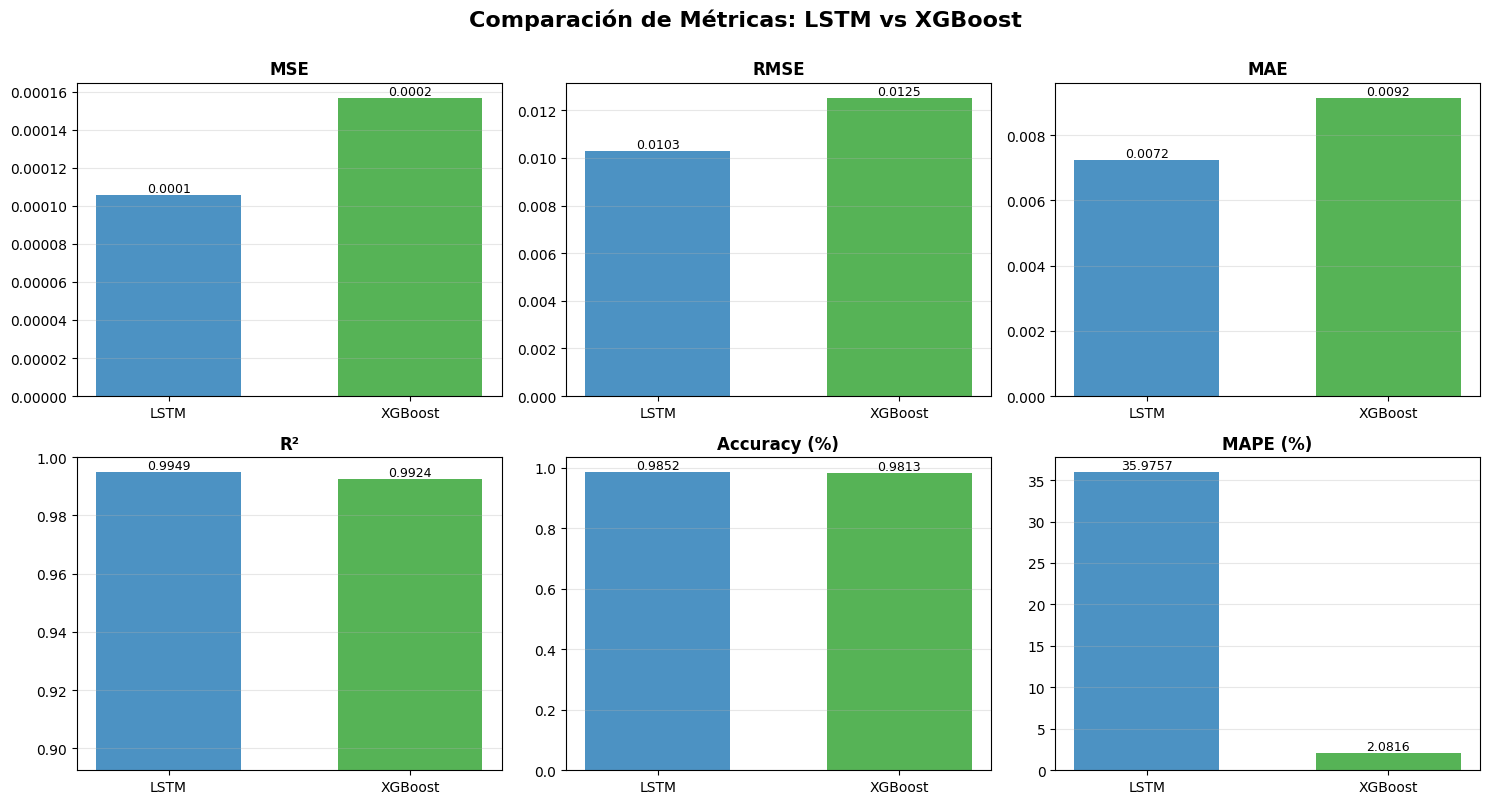

In [48]:
metricas_comparacion = pd.DataFrame({
    'Métrica': ['MSE', 'RMSE', 'MAE', 'R²', 'Accuracy (%)', 'MAPE (%)'],
    'LSTM': [mse_lstm, rmse_lstm, mae_lstm, r2_lstm, accuracy_lstm, mape_lstm],
    'ARIMA': [mse_arima, rmse_arima, mae_arima, r2_arima, accuracy_arima, mape_arima],
    'XGBoost': [mse_xgb, rmse_xgb, mae_xgb, r2_xgb, accuracy_xgb, mape_xgb]
})

print(metricas_comparacion.to_string(index=False))

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
metricas = ['MSE', 'RMSE', 'MAE', 'R²', 'Accuracy (%)', 'MAPE (%)']
colores = ['#1f77b4', '#2ca02c']

for idx, metrica in enumerate(metricas):
    ax = axes[idx // 3, idx % 3]
    valores = metricas_comparacion[metricas_comparacion['Métrica'] == metrica][['LSTM', 'XGBoost']].values[0]
    barras = ax.bar(['LSTM', 'XGBoost'], valores, color=colores, alpha=0.8, width=0.6)
    ax.set_title(metrica, fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    if metrica == 'R²':
        ax.set_ylim([min(valores) - 0.1, 1.0])
    
    for barra in barras:
        altura = barra.get_height()
        ax.text(barra.get_x() + barra.get_width()/2., altura, f'{altura:.4f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Comparación de Métricas: LSTM vs XGBoost', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()